<a href="https://colab.research.google.com/github/rodrigoclira/mindspore-playground/blob/main/mindspore_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting MNIST with MindSpore 

Installing MindSpore using pip

In [2]:
!pip install mindspore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 25.7 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


Checking the installation and mindspore version

In [1]:
!python -c "import mindspore;print(mindspore.__version__)"

1.10.0


# Loading MNIST Dataset

Creating folders and downloading MNIST dataset

In [16]:
!apt-get install tree # installing auxiliary software

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 0s (99.4 kB/s)
Selecting previously unselected package tree.
(Reading database ... 128221 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...


In [17]:
!mkdir -p ./datasets/MNIST_Data/train ./datasets/MNIST_Data/test
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte --no-check-certificate
!tree ./datasets/MNIST_Data

--2023-03-02 02:35:10--  https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte
Resolving mindspore-website.obs.myhuaweicloud.com (mindspore-website.obs.myhuaweicloud.com)... 121.36.121.84, 49.4.112.92, 49.4.112.91
Connecting to mindspore-website.obs.myhuaweicloud.com (mindspore-website.obs.myhuaweicloud.com)|121.36.121.84|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘./datasets/MNIST_Data/train/train-labels-idx1-ubyte’ not modified on server. Omitting download.

--2023-03-02 02:35:11--  https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte
Resolving mindspore-website.obs.myhuaweicloud.com (mindspore-website.obs.myhuaweicloud.com)... 121.36.121.84, 49.4.112.92, 49.4.112.91
Connecting to mindspore-website.obs.myhuaweicloud.com (mindspore-website.obs.myhuaweicloud.com)|121.36.121.84|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘./datas

The type of mnist_ds: <class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 6


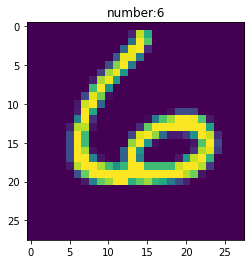

In [4]:
import os
from mindspore import context
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

train_data_path = "./datasets/MNIST_Data/train"
test_data_path = "./datasets/MNIST_Data/test"
ds.config.set_num_parallel_workers(1)
mnist_ds = ds.MnistDataset(train_data_path)
print('The type of mnist_ds:', type(mnist_ds))
# print("Number of pictures contained in the mnist_ds：", mnist_ds.get_dataset_size())

dic_ds = mnist_ds.create_dict_iterator()
item = next(dic_ds)
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("The item of mnist_ds:", item.keys())
print("Tensor of image in item:", img.shape)
print("The label of item:", label)

plt.imshow(np.squeeze(img))
plt.title("number:%s"% item["label"].asnumpy())
plt.show()


In [30]:
from mindspore.dataset.vision import HWC2CHW, Rescale, Resize
from  mindspore.dataset.transforms import TypeCast
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """
    create dataset for train or test

    Args:
        data_path (str): Data path
        batch_size (int): The number of data records in each group
        repeat_size (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # according to the parameters, generate the corresponding data enhancement method
    resize_op = Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = Rescale(rescale_nml, shift_nml)
    rescale_op = Rescale(rescale, shift)
    hwc2chw_op = HWC2CHW()
    type_cast_op = TypeCast(mstype.int32)

    # using map to apply operations to a dataset
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    #mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    #mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

ms_dataset = create_dataset(train_data_path)
print('Number of groups in the dataset:', ms_dataset.get_dataset_size())


Number of groups in the dataset: 1875


In [31]:
data = next(ms_dataset.create_dict_iterator(output_numpy=True))
images = data["image"]
labels = data["label"]
print('Tensor of image:', images.shape)
print('Labels:', labels)


Tensor of image: (32, 32, 32, 1)
Labels: [4 7 0 3 9 0 4 6 2 0 1 8 5 9 2 5 2 9 8 7 9 8 1 9 4 8 3 8 2 7 2 6]


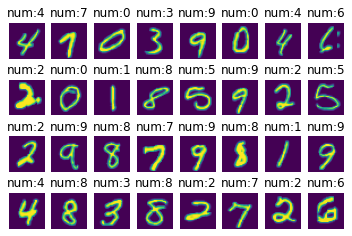

In [32]:
count = 1
for i in images:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i))
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()


## Building the LeNet Model

In [40]:
import mindspore.nn as nn
from mindspore.common.initializer import Normal

class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channel, out_channels=6, kernel_size = (5,5), pad_mode='same')
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size = (5,5), pad_mode = 'valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

network = LeNet5()
print("layer conv1:", network.conv1)
print("*"*40)
print("layer fc1:", network.fc1)


TypeError: ignored

In [34]:
from mindspore.train.callback import Callback

# custom callback function
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        cur_step = (cur_epoch-1)*1875 + cb_params.cur_step_num
        self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
        self.steps_loss["step"].append(str(cur_step))
        if cur_step % 125 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])


In [35]:
import mindspore.nn as nn
from mindspore.nn import SoftmaxCrossEntropyWithLogits

lr = 0.01
momentum = 0.9

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


In [38]:
import os
from mindspore import Tensor, Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.nn import Accuracy

epoch_size = 1
mnist_path = "./datasets/MNIST_Data"
model_path = "./models/ckpt/mindspore_quick_start/"

repeat_size = 1
ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
eval_dataset = create_dataset(os.path.join(mnist_path, "test"), 32)

# clean up old run files before in Linux
os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))

# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()} )

# save the network model and parameters for subsequence fine-tuning
config_ck = CheckpointConfig(save_checkpoint_steps=375, keep_checkpoint_max=16)
# group layers into an object with training and evaluation features
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=model_path, config=config_ck)

steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
# collect the steps,loss and accuracy information
step_loss_acc_info = StepLossAccInfo(model , eval_dataset, steps_loss, steps_eval)

model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(125), step_loss_acc_info], dataset_sink_mode=False)


[WARNING] ME(955:140014237923136,MainProcess):2023-03-02-03:26:47.688.57 [mindspore/train/model.py:1077] For StepLossAccInfo callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


ValueError: ignored

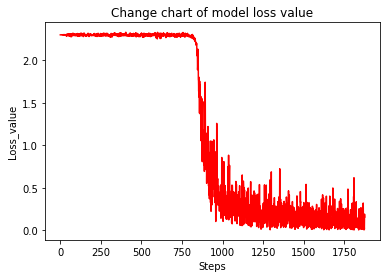

In [12]:
steps = steps_loss["step"]
loss_value = steps_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Change chart of model loss value")
plt.show()


In [13]:
from mindspore import load_checkpoint, load_param_into_net

# testing relate modules
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("./models/ckpt/mindspore_quick_start/checkpoint_lenet-1_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc))

test_net(network, model, mnist_path)


[WARNING] ME(955:140014237923136,MainProcess):2023-03-02-02:29:40.650.312 [mindspore/dataset/core/validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(955:140014237923136,MainProcess):2023-03-02-02:29:40.652.496 [mindspore/dataset/core/validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(955:140014237923136,MainProcess):2023-03-02-02:29:40.656.148 [mindspore/dataset/core/validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(955:140014237923136,MainProcess):2023-03-02-02:29:40.659.234 [mindspore/dataset/cor

============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9670472756410257} ==============


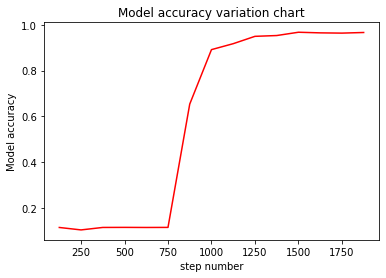

In [14]:
def eval_show(steps_eval):
    plt.xlabel("step number")
    plt.ylabel("Model accuracy")
    plt.title("Model accuracy variation chart")
    plt.plot(steps_eval["step"], steps_eval["acc"], "red")
    plt.show()

eval_show(steps_eval)


[WARNING] ME(955:140014237923136,MainProcess):2023-03-02-02:30:01.819.061 [mindspore/dataset/core/validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(955:140014237923136,MainProcess):2023-03-02-02:30:01.824.903 [mindspore/dataset/core/validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(955:140014237923136,MainProcess):2023-03-02-02:30:01.828.676 [mindspore/dataset/core/validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(955:140014237923136,MainProcess):2023-03-02-02:30:01.832.443 [mindspore/dataset/cor

Row 2, column 8 is incorrectly identified as 8, the correct value should be 0 

Row 4, column 7 is incorrectly identified as 3, the correct value should be 2 

[7 7 5 5 1 7 7 8 0 6 8 0 5 7 3 8 7 0 2 3 5 5 6 4 7 2 5 5 3 1 3 5] <--Predicted figures
[7 7 5 5 1 7 7 8 0 6 8 0 5 7 3 0 7 0 2 3 5 5 6 4 7 2 5 5 3 1 2 5] <--The right number


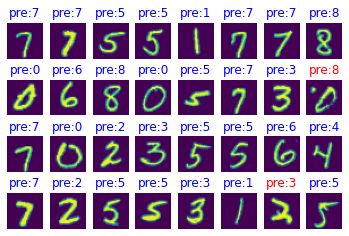

In [15]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()


output = model.predict(Tensor(data['image']))
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly!")
print(pred, "<--Predicted figures")
print(labels, "<--The right number")
plt.show()
